Convert origami crease pattern folding image into an image sutable for laser etching to etch the paper before performing the folds. The idea is to do this step instead of pre-creasing the paper by hand.

crease pattern folding is explored by [Robert J. Lang](https://langorigami.com/crease-patterns/). I tunned this notebook to work with [images](https://www.flickr.com/photos/156686586@N07/sets/72157711291668357/) that follow this [YouTube series by OrigamiByBoice](https://www.youtube.com/watch?v=slpw01Vpg3U&list=PLT_uBKzl3wcczX-YpbB7b_DMK4TAgtV20) on how to fold the patterned origami paper.

In [1]:
# download an example
# To get a link to a flickr image hover your mouse over the download button at the bottom right
# right click and Copy Link then open a new borwser tab and paste the link
# hover over the image and Copy Image Address and paste it in the curl command below...
#!curl https://live.staticflickr.com/65535/48881544006_519135ff40_o.jpg --output ./images/input.jpg
!curl https://live.staticflickr.com/65535/48988517087_685ed7ee89_o.jpg --output ./images/input.jpg
#!curl https://live.staticflickr.com/65535/49016177426_e07b92a269_o.jpg --output ./images/input.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 86567  100 86567    0     0   794k      0 --:--:-- --:--:-- --:--:--  790k


In [2]:
import numpy as np
import cv2
import math
from matplotlib import pyplot as plt

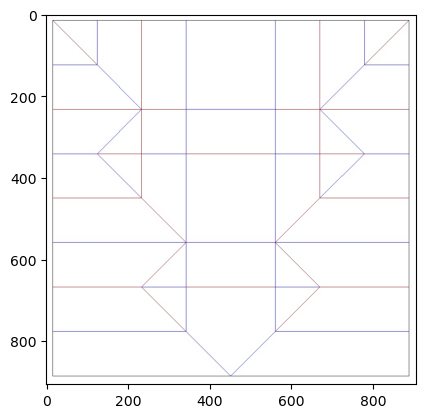

(906, 907, 3)

In [3]:
imgcolor = cv2.imread('images/input.jpg')
plt.imshow(imgcolor)
plt.show()
imgcolor.shape

truncate to a square

In [4]:
# truncate to a square
w,h,c = imgcolor.shape
if w < h:
    imgcolor = imgcolor[:,:w,:]
elif w > h:
    imgcolor = imgcolor[:h,:,:]
w,h,c = imgcolor.shape

In [5]:
# identify which RGB values are used
d = {}
for x in range(w):
    for y in range(w):
        c = ((imgcolor[x,y,0]+5)//10,(imgcolor[x,y,1]+5)//10,(imgcolor[x,y,2]+5)//10)
        if c in d:
            d[c] += 1
        else:
            d[c] = 1
l = [(c,v) for (c,v) in d.items() if min(c) < 10]
l.sort(key = lambda cv: -cv[1])
l[:10]

[((0, 0, 0), 3383),
 ((5, 5, 14), 3258),
 ((11, 2, 2), 1491),
 ((12, 2, 2), 1480),
 ((5, 5, 15), 971),
 ((6, 6, 12), 403),
 ((5, 5, 13), 314),
 ((8, 2, 2), 282),
 ((10, 2, 2), 265),
 ((8, 2, 3), 94)]

In [6]:
# https://medium.com/analytics-vidhya/skeletonization-in-python-using-opencv-b7fa16867331
def getskeleton(img):
    # Step 1: Create an empty skeleton
    size = np.size(img)
    skel = np.zeros(img.shape, np.uint8)

    # Get a Cross Shaped Kernel
    element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))

    # Repeat steps 2-4
    while True:
        #Step 2: Open the image
        open = cv2.morphologyEx(img, cv2.MORPH_OPEN, element)
        #Step 3: Substract open from the original image
        temp = cv2.subtract(img, open)
        #Step 4: Erode the original image and refine the skeleton
        eroded = cv2.erode(img, element)
        skel = cv2.bitwise_or(skel,temp)
        img = eroded.copy()
        # Step 5: If there are no white pixels left ie.. the image has been completely eroded, quit the loop
        if cv2.countNonZero(img)==0:
            break
    #
    return skel

In [7]:
#https://stackoverflow.com/questions/45322630/how-to-detect-lines-in-opencv
def getchan(imgcolor,rgb = [0,0,0],dif=0,maxc=-1):
    mask = np.zeros(imgcolor.shape[:-1],np.uint8)
    for x in range(imgcolor.shape[0]):
        for y in range(imgcolor.shape[1]):
            px = imgcolor[x,y,:]
            if maxc >= 0 and maxc != np.argmax(px):
                continue
            if dif > 0 and max(px) - min(px) < dif:
                continue
            if dif < 0 and max(px) - min(px) > -dif:
                continue
            f = True
            for c,t in enumerate(rgb):
                if t > 0 and px[c] < t:
                    f = False
                    break
                if t < 0 and px[c] > -t:
                    f = False
                    break
            if f:
                mask[x,y] = 255

#     kernel_size = 5
#     mask = cv2.GaussianBlur(mask,(kernel_size, kernel_size),0)

#     kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3)) # MORPH_CROSS MORPH_ELLIPSE
#     n = 4
#     for i in range(n):
#         mask = cv2.dilate(mask,kernel)
#     for i in range(n):
#         mask = cv2.erode(mask,kernel)

    mask = getskeleton(mask)
        
#     mask = cv2.Canny(mask,200,250)
    
#     mask = getskeleton(mask)

#     kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3)) # MORPH_CROSS MORPH_ELLIPSE
#     n = 4
#     for i in range(n):
#         mask = cv2.dilate(mask,kernel)
#     for i in range(n):
#         mask = cv2.erode(mask,kernel)
           
    return mask

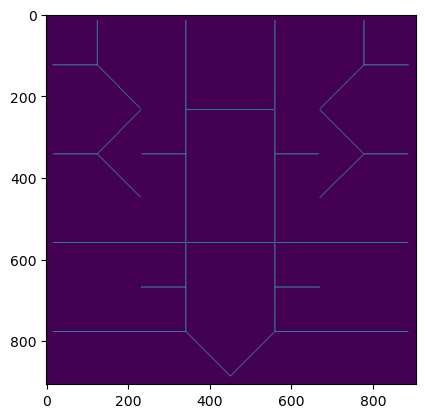

In [8]:
imgB = getchan(imgcolor, rgb = [-140,-140,70],dif = 20,maxc=2)
plt.imshow(imgB) #, interpolation='nearest')
plt.show()

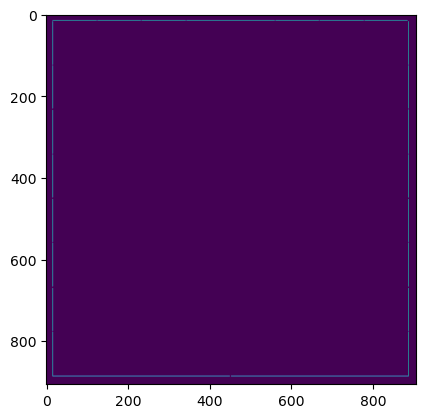

In [9]:
imgC = getchan(imgcolor,rgb = [-140,-140,-140], dif = -20)
plt.imshow(imgC) #, interpolation='nearest')
plt.show()

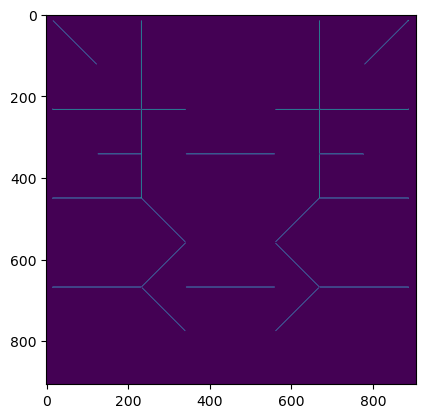

In [10]:
imgR = getchan(imgcolor, rgb = [40,-140,-140],dif = 20,maxc=0)
plt.imshow(imgR) #, interpolation='nearest')
plt.show()

In [11]:
def getsegments(img,code=0,straight=True):
    if straight:
        rho = 0.5  # distance resolution in pixels of the Hough grid
        theta = np.pi / 360  # angular resolution in radians of the Hough grid
        threshold = 10 # minimum number of votes (intersections in Hough grid cell)
        min_line_length = 10  # minimum number of pixels making up a line
        max_line_gap = 20  # maximum gap in pixels between connectable line segments

        # Run Hough on edge detected image
        # Output "lines" is an array containing endpoints of detected line segments
        lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)
    #     lsd = cv2.createLineSegmentDetector(0)
    #     lines = lsd.detect(img)[0]
        segments = [(x1,y1,x2,y2,code) for polygon in lines for (x1,y1,x2,y2) in polygon]
    else:
        contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        # RETR_TREE RETR_EXTERNAL RETR_LIST RETR_CCOMP
        # CHAIN_APPROX_NONE CHAIN_APPROX_SIMPLE CHAIN_APPROX_TC89_L1 CHAIN_APPROX_TC89_KCOS

        segments = []
        for contour in contours:
            # Approximate the contour with a polygon
    #        polygon = cv2.approxPolyDP(contour, 0.002*cv2.arcLength(contour, True), True)
            polygon = contour
            polygon = np.reshape(polygon,(-1,2))

            #print(polygon)

            # draw polygon lines
            for idx, (x,y) in enumerate(polygon):
                if idx == 0:
                    xold = x
                    yold = y
                else:
                    segments.append((xold,yold,x,y,code))
                    xold = x
                    yold = y
    return segments

In [12]:
segC = getsegments(imgC)
segR = getsegments(imgR,1)
segB = getsegments(imgB,2)

In [13]:
# plot segments in an output image, using their code.
def plot(segments,output):
    c=(0,0,0)

    for (x1,y1,x2,y2,code) in segments:
        if code == 0:
            w = 4
            dash = 0
        elif code ==1:
            w = 1
            dash = 0
        else:
            w = 1
            dashblack = 2
            dashwhite = 6
            dash = dashblack + dashwhite
        if x1 > x2:
            x1,x2 = x2,x1
            y1,y2 = y2,y1
        if dash:
            l = math.sqrt((x2-x1)**2 + (y2-y1)**2)
            n = l/dash
            dx = (x2-x1)/n
            ddx = dx * dashblack/dash
            dy = (y2-y1)/n
            ddy = dy * dashblack/dash
            n = int(n)+1
            for i in range(n):
                xx1 = int(x1 + dx * i + 0.5)
                xx2 = int(x1 + dx * i + ddx + 0.5)
                yy1 = int(y1 + dy * i + 0.5)
                yy2 = int(y1 + dy * i + ddy + 0.5)                    
                output = cv2.line(output, (xx1, yy1), (xx2, yy2), c, w)
        else:
            output = cv2.line(output, (int(x1+0.5), int(y1+0.5)), (int(x2+0.5), int(y2+0.5)), c, w)
    return output

In [14]:
output = np.ones(imgcolor.shape, np.uint8)*255

In [15]:
output = plot(segC, output)

In [16]:
output = plot(segR, output)

In [17]:
output = plot(segB, output)

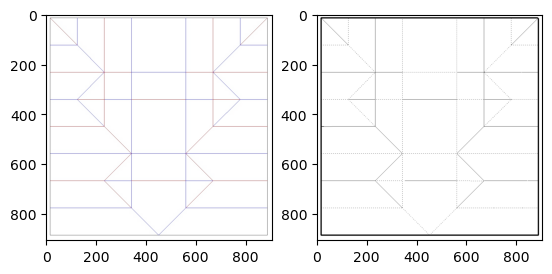

In [18]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(imgcolor)
axarr[1].imshow(output)

I used the output image to etch the paper using Creality Laser kit for Ender 3 S1.
My origami paper is 150mm x 150mm.
I open the image in Creality Print and scale the image to 145mm x 145mm and move it to 75mm x 75mm,
decreased Power Rate to 40% and increase Work Speed to 3000mm/min

In [19]:
cv2.imwrite('images/output.png',output)

True

but this was very slow, more than an hour, because the Creality Printer App generates gcode that scans the entire surface of the paper. So instead the code below generates its own vectorized gcode.

In [20]:
def seg_len(segments,x=0,y=0):
    l = 0.
    for (x0,y0,x1,y1,c) in segments:
        l += np.sqrt((x-x0)**2 + (y-y0)**2)
        l += np.sqrt((x1-x0)**2 + (y1-y0)**2)
        x = x1
        y = y1
    return l

In [21]:
def sort_segments_gridi(segments,x=0,y=0):
    segments = segments.copy()
    out_segments = []
    while len(segments):
        distances = [(x-x0)**2 + (y-y0)**2 for (x0,y0,x1,y1,code) in segments]
        reverse = [(x-x1)**2 + (y-y1)**2 for (x0,y0,x1,y1,code) in segments]
        min_distance = np.argmin(distances)
        min_reverese = np.argmin(reverse)
        if reverse[min_reverese] < distances[min_distance]:
            (x0,y0,x1,y1,code) = segments[min_reverese]
            out_segments.append((x1,y1,x0,y0,code))
            del segments[min_reverese:min_reverese+1]
        else:
            out_segments.append(segments[min_distance])
            del segments[min_distance:min_distance+1]
        x = out_segments[-1][2]
        y = out_segments[-1][3]
    return out_segments

In [22]:
len(segC),seg_len(segC)

(4, 7691.884483479523)

In [23]:
segC = sort_segments_gridi(segC)
seg_len(segC)

3503.1743528865804

In [24]:
seg = segR + segB
len(seg),seg_len(seg)

(60, 35470.57598629945)

In [25]:
seg = sort_segments_gridi(seg)
seg_len(seg)

11511.476642392285

In [26]:
seg += segC # engrave frame last

In [27]:
def seg2gcode(f,segments,shape,w0=5,h0=5,w=140,h=140):
    dw = w/shape[0]
    dh = h/shape[1]
    
    for (x1,y1,x2,y2,code) in segments:
        if code == 0 or code == 1:
            s = 999 if code == 0 else 299
            f.write(f"G0X{(x1*dw + w0):.3f}Y{(y1*dh + h0):.3f}\n")
            f.write(f"G1X{(x2*dw + w0):.3f}Y{(y2*dh + h0):.3f}S{s}\n")
        else:
            s = 500
            dashblack = 5
            dashwhite = 5
            dash = dashblack + dashwhite

            l = np.sqrt((x2-x1)**2 + (y2-y1)**2)
            n = l/dash
            dx = (x2-x1)/n
            ddx = dx * dashblack/dash
            dy = (y2-y1)/n
            ddy = dy * dashblack/dash
            n = int(n)+1
            for i in range(n):
                xx1 = x1 + dx * i
                yy1 = y1 + dy * i
                f.write(f"G0X{(xx1*dw + w0):.3f}Y{(yy1*dh + h0):.3f}\n")
                
                xx2 = xx1 + ddx
                yy2 = yy1 + ddy
                f.write(f"G1X{(xx2*dw + w0):.3f}Y{(yy2*dh + h0):.3f}S{s}\n")

In [28]:
f = open('output.gcode','w')

In [29]:
header = """;Header Start
;estimated_time(s): 60
;MAXX: 145
;MAXY: 145
;MINX: 5
;MINY: 5
;Header End


G92 X0 Y0 Z0
G90
G0 F3000
G1 F1500
M3 I
"""
f.write(header)

131

In [30]:
seg2gcode(f,seg,imgcolor.shape)

In [31]:
f.write("G1X0Y0S0\n")
f.close()